# Decoding errors and their effect on the QEC
In our thesis, we investigated the performance of the smallest possible quantum error correcting code (QECC) capable of correcting any single qubit error. This code, the $[\![5,1,3]\!]$ stabilizer code, could be a potentially interesting test case for error correction on near-term hardware. We identified the main bottleneck as a form of decoding error cause by noise occurring in between the stabilizer measurements.
 
## Recap of the code
The notation $[\![5,1,3]\!]$ refers to how the code uses five qubits to redundantly store the information of a single logical qubit, and has *distance* 3. The distance tells us that it takes three single qubit operations to map the $|0_L\rangle$ state to the $|1_L\rangle$ state and vice versa. 

Errors are detected using the four stabilizer generators
$$
g_{1} = X Z Z X I \\
g_{2} = I X Z Z X \\
g_{3} = X I X Z Z \\
g_{4} = Z X I X Z.
$$
These are Hermitian observables with eigenvalues $+1$ and $-1$, and error-free states are defined as the simultaneous eigenvectors with an eigenvalue of $+1$ for each of them (which are said to be stabilized). Measuring these four observables has to be done one at a time using the circuit below. This gives a four bit string were we refer to $'+1'$ outcomes as $'0'$ and $'-1'$ as $'1'$ and write the measurements from right to left. This *syndrome* uniquely identifies any single qubit Pauli error on any of the qubits. Here, $'0000'$ signifies an error free state, and e.g. $'0110'$ signifies the occurrence of $X_4$, i.e. a bit-flip error on the fourth qubit. 

*(This embedded image cannot be rendered in vscode)*

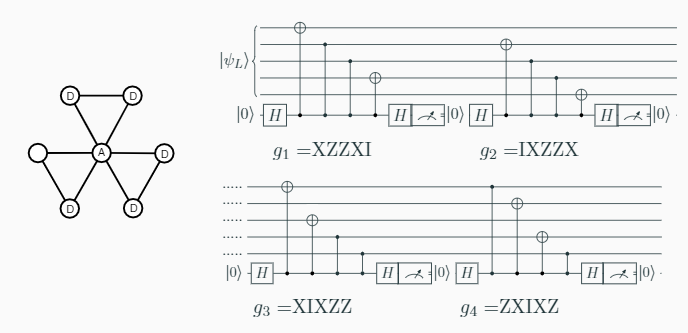

## In more detail
Since the logical zero and one states are both $'+1'$ eigenstates, any superposition $\alpha |0_L\rangle+\beta|1_L\rangle$ of them will be too. Starting from such an arbitrary logical state, every single-qubit Pauli operator $E$ will map it to a *unique* orthogonal subspace. One can then measure which of these orthogonal subspaces the state resides in and map it back to the codespace without affecting the underlying state.

The codespace is 2-dimensional, and this property requires an additional 2-dimensional orthogonal subspace for every Pauli operator. There are three ($X$, $Y$ and $Z$) Pauli operators for each qubit, which requires $2 \cdot (1+3\cdot5) = 32$ dimensions. This is exactly satisfied by the $2^5=32$ dimensional Hilbert space. The $[\![5,1,3]\!]$ code is the smallest where this is possible. 

We can thus divide the Hilbert space into four orthogonal subspaces. The first is the one dimensional space of only $|0_L\rangle$. The second is the 15-dimensional space of states a distance 1 from $|0_L\rangle$, i.e. the space spanned by every state that can be reached from $|0_L\rangle$ through some single qubit operation. The third is the 15-dimensional space of states a distance 2 from $|0_L\rangle$, and the fourth is the space spanned by $|1_L\rangle$. Note that states with a distance 1 from $|0_L\rangle$ are a distance 2 from $|1_L\rangle$ and vice versa.

## Decoding errors
How do decoding errors impact the performance of the error correction? Let's run some simulations and see. We will initialize the state as $|0_L\rangle$ and measure it's overlap with with the four subspaces mentioned above. That is, the probability of finding the state in the particular subspace.

/home/sebastian/miniconda3/envs/exjobb-qiskit/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Loading simulation results from file


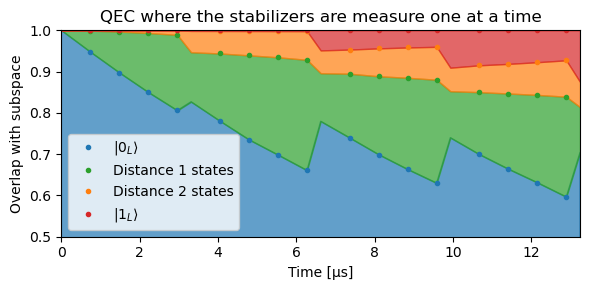

In [1]:
# Set up simulations and load the data
from simulator_program.data_analysis_tools import default_simulate_persist_to_file
from simulator_program.custom_noise_models import standard_times, standard_times_delay, GateTimes
import decoding_errors
file_name = 'decoding_data/cache.dat'

## Use the commented code below to chose settings from pre-loaded simulation data
## Print the kwargs for the runs that are saved in the file
# decoding_errors.print_saved_runs(file_name)
## Copy paste the output this line to assign the kwargs dict
# kwargs = {k:v for k,v in {('idle_delay', 'before'), ('include_barriers', True), ('include_fifth_stabilizer', False), ('n_cycles', 3), ('generator_snapshot', True), ('encoding', False), ('reset', True), ('idle_snapshots', 2), ('conditional', False), ('recovery', True), ('final_measure', False)}}
## Verify that the selected simulations exist in the data file
# print('Is a run with these settings saved?', decoding_errors.check_if_saved(
#     kwargs, T1, T2, gate_times, file_name=file_name))

kwargs = {
    'n_cycles': 4,
    'reset': True,
    'recovery': True,
    'encoding': False,
    'conditional': False,
    'include_barriers': True,
    'generator_snapshot': True,
    'idle_snapshots': 0,
    'final_measure': False,
    'idle_delay': 'before',
    'include_fifth_stabilizer': False}


T1 = [40e3]*5+[100000000000, 100000000000]
T2 = [60e3]*5+[100000000000, 100000000000]

# Standard operation times (single qb 20 ns, 2qb 100 ns etc.)
gate_times = standard_times

n_shots = 1024*2

save_to_file = False
overwrite = False

results, times = default_simulate_persist_to_file(
    kwargs, T1, T2, gate_times, n_shots, file_name=file_name, overwrite=overwrite, save_to_file=save_to_file)

decoding_errors.plot_overlap(results, times, title='QEC where the stabilizers are measure one at a time',**kwargs)

This is how normal repeated QEC looks. The stabilizers have to be measured one at a time.

As a comparison, we let the qubits idle for the same amount of time that one cycle of error correction normally takes and make the stabilizer measurements instantaneous, i.e. we introduce the same amount of noise but outside the correction cycles. This allows us to remove the decoding errors and we get the intended behavior.

Loading simulation results from file


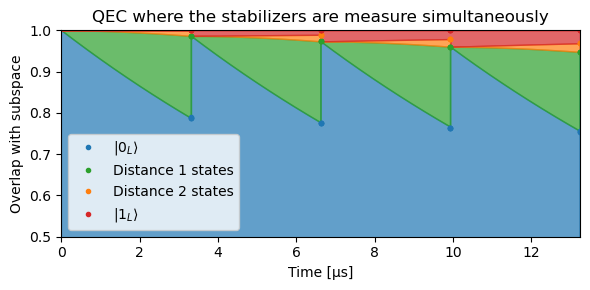

In [2]:
# Make a copy but with one modified entry
kwargs2 = dict(kwargs, idle_snapshots=10)

# All operations are instant, idle the qubits the duration of one cycle
gate_times2 = GateTimes(0, 0, {'delay': 3310})

results2, times2 = default_simulate_persist_to_file(
    kwargs2, T1, T2, gate_times2, n_shots, file_name=file_name, overwrite=overwrite, save_to_file=save_to_file)

decoding_errors.plot_overlap(results2, times2,title='QEC where the stabilizers are measure simultaneously', **kwargs2)

Notice how the entire subspace of distance-1 states gets mapped back to the $|0_L\rangle$ state, while the subspace of distance-2 states gets mapped to the $|1_L\rangle$ state, as intended. In the previous plot, only a small part of the distance-1 space got mapped to $|0_L\rangle$, while a the majority seems to have stayed in the distance-1 space and some of it even seems to have ended up in the distance 2 region.

Let's investigate what is happening during the correction that is causing this behavior. We will pause the simulation before the recovery step and 
look at the overlap with each of the 32 basis states. For example, imagine that we measured the syndrome $'0110'$ and that our state is described by $\rho_{0110}$. Since $X_4$ is the error that causes this syndrome, we should expect that $\rho_{0110}$ has a large overlap with the state $X_4 |0_L\rangle$. This is given by the quantum state fidelity $\langle 0_L| X_4^\dagger \rho_{0110} X_4 |0_L\rangle$, which can also be viewed as the fidelity to the $|0_L\rangle$ state after evolving it by the reverse error $X_4^\dagger$. Let $E_s$ be a single qubit error labeled by its syndrome $s\in\{0000,0001,...,1111\}$. On the left side of the plot below is shown the fidelity to the distance $\leq1$ states, $\langle 0_L| E_{s'}^\dagger \rho_{s} E_{s'} |0_L\rangle$, and on the right the fidelity to the distance $\geq2$ states, $\langle 1_L| E_{s'}^\dagger \rho_{s} E_{s'} |1_L\rangle$.

The rightmost column shows the fraction of runs where the specified syndrome was measured (high values correspond to probable outcomes). The second rightmost column shows the maximum fidelity to any pure state, which is given by the largest eigenvalue of $\rho$. This corresponds to the fidelity after applying the best possible arbitrary unitary recovery operation.

Loading simulation results from file


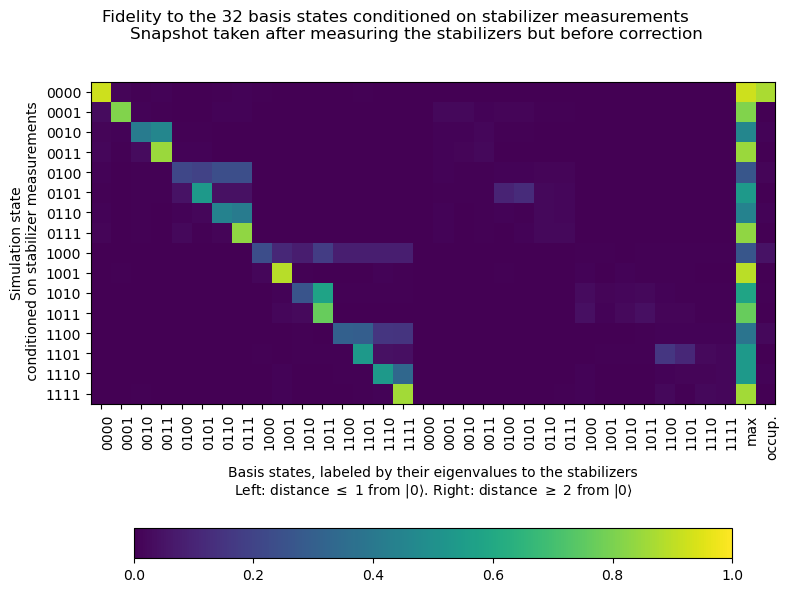

In [3]:
# Here, we turn off the recovery step (the stabilizers are still measured) but tell 
# the simulator to condition the density matrix snapshots on the measurement outcomes
kwargs = dict(kwargs, n_cycles=2, recovery=False,
              conditional=True, idle_snapshots=2)

# Conditioning the snapshots requires more shots
n_shots = 1024*8

results, times = default_simulate_persist_to_file(
    kwargs, T1, T2, gate_times, n_shots, file_name=file_name, overwrite=overwrite, save_to_file=save_to_file)

decoding_errors.plot_correction_matrix(results, **kwargs)

Here we can see the source of the problem. Syndromes that begin with zeros have 'tails' of fidelity with the syndromes that have ones in those beginning bits (remember that the binary strings are written from right to left). This is caused by the fact that we need to measure generators one at a time. For example, if the system starts in an error-free $'0000'$ state and the error $Y_1=E_{1101}$ occurs in between the second and the third stabilizer measurement, then the first (rightmost) bit would be incorrectly identified as a zero, causing the syndrome to be read as $'1100'$. If one then tries to correct using this syndromes, which corresponds to an $X_5$ error, it will effectively cause two errors and map the state to the distance 2 subspace.

We can see that the $'1000'$ syndrome is particularly problematic. What if we, given that this syndrome occurred during the first cycle, measure each stabilizers again and look at the overlap matrix for the new syndromes? 

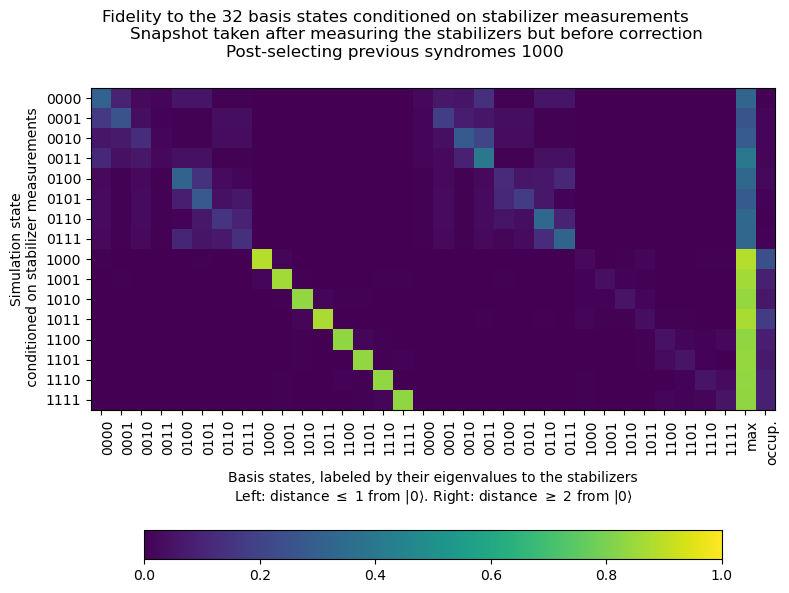

In [4]:
# List of syndromes that we assume have occured in the previous cycle(s)
previous_syndromes = ['1000']  

decoding_errors.plot_correction_matrix(results, previous_syndromes, **kwargs)

We can see that when we remeasure the generators, the new syndrome correctly identifies which error had actually occurred. This is true assuming that the last bit comes out as a $'1'$, but looking at the occupation that happens most of the time. 